# Define Nested Areas of Interest and Mark Fixations Inside Them

**Where we start:**
This notebook is the second part of the data analysis pipeline described in our [blog post][blog_post_link]. We assume that you already have an idea of what your reference image and fixation data look like. If you don't, please check out the notebook ["Exploring Data from the Reference Image Mapper"][notebook_link].

At this point, the data files from your Reference Image Mapper Enrichment are inside one single, unzipped folder, and that folder is located in the same directory from where you run this code. If you also want to save figures, you need to have an empty folder called "figures" in the same directory.

This notebook is designed around the standing condition where participants were instructed to stand in front of and look at specific paintings for 10 seconds each. 

**Dependencies:**
[matplotlib][matplotlib_link], [OpenCV][opencv_link], [pandas][pandas_link] and [numpy][numpy_link] are installed.

**What we do:**
We mark areas of interest on our reference image with OpenCV's selectROI function. Then, we match the observed fixations to AOIs and save a data file with this matching. At each step, we visualize the result. In this example, there are multiple AOIs inside one reference image.

**What we get:**
A csv file with the same data as the fixations.csv file from the reference image mapper, including one additional column indicating on which (if any) AOI the fixation occurred.


[notebook_link]: https://github.com/pupil-labs/gallery_demo_analysis/blob/main/0_Exploring%20Data%20from%20the%20Reference%20Image%20Mapper.ipynb
[matplotlib_link]: https://matplotlib.org/ 
[opencv_link]: https://opencv.org/
[pandas_link]: https://pandas.pydata.org/
[numpy_link]:https://numpy.org/
[blog_post_link]: https://pupil-labs.com/blog/news/demo-workspace-walkthrough-part2/

## Import Needed Libraries and Define Paths

In [1]:
import cv2
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# larger labels are nicer to read
plt.rcParams.update({"font.size": 18})

# ACTION NEEDED: define the path on your own PC
path_to_reference_image_mapper = (
    "./Viewing_Paintings_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"
)

## Load the Reference Image and Fixations
You can find a more detailed explanation and visualisations of these steps in the previous notebook ["Exploring Data from the Reference Image Mapper"][notebook_link]

In [2]:
# load the reference image
reference_image = cv2.imread(f"{path_to_reference_image_mapper}/reference_image.jpeg")
# convert color format to RGB
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
# import fixation data
fixations = pd.read_csv(f"{path_to_reference_image_mapper}/fixations.csv")
# select fixations to the reference image
fixations = fixations[fixations["fixation detected in reference image"]]

## Defining Areas of Interest

In the next step, we will mark our AOIs on the reference image. In the blog post, we treat each individual painting as an AOI. But you are not constrained to that. For example, you could mark faces or information plates – literally anything that interests you can be an AOI!

Here, we give you two choices:

Executing the first cell below ("Marking Areas of Interest by Hand") will give you the opportunity to define AOIs yourself.

Executing the second cell below ("Loading Pre-Defined Areas of Interest") loads those AOIs we used for our blog post. Note - they won't make any sense if you are not working with the Reference Image Mapper "multiple_paintings_standing" from our [Demo Workspace][workspace_link]

[workspace_link]: https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9

## Marking Areas of Interest by Hand

Mark the AOIs by clicking in the upper left corner where you want your AOI to start. Then drag while keeping the mouse pressed until the blue rectangle is sized correctly. Release the mouse and hit enter or the space bar when you are happy with your selection. If you are not, you can start over by simply marking a new area. 
Repeat this process until you have marked all AOIs needed. Close the selection with the escape key.

In [3]:
# resize the image before labelling AOIs makes the image stay in the screen boundaries
scaling_factor = 0.25
scaled_image = reference_image.copy()
scaled_image = cv2.resize(
    scaled_image, dsize=None, fx=scaling_factor, fy=scaling_factor
)

# mark the AOIs
scaled_aois = cv2.selectROIs("AOI Annotation", scaled_image)
cv2.destroyAllWindows()

# scale back the position of AOIs
aois = scaled_aois / scaling_factor
print(scaled_aois)

## Loading Pre-Defined Areas of Interest
If you want to use the same AOIs that we used in our blog post, remove the comments from the code cell below and execute it.

In [4]:
# aois = [[ 540.,  152.,  528.,  532.],
#         [1484.,  724.,  344.,  420.],
#         [1892.,  320.,  624.,  832.],
#         [2588.,  800.,  456.,  536.],
#         [3056.,  936.,  440.,  420.],
#         [3252.,  256.,  424.,  416.],
#         [ 908., 1292., 1604.,  804.],
#         [2632., 1396.,  840.,  620.],
#         [ 684., 2484.,  452.,  472.],
#         [1240., 2320.,  332.,  348.],
#         [1976., 2316.,  564.,  652.],
#         [2580., 2072.,  864.,  928.]]

## Overlaying Areas of Interest on the Reference Image
The next step is to visually check whether the AOIs we defined match up with our reference image.

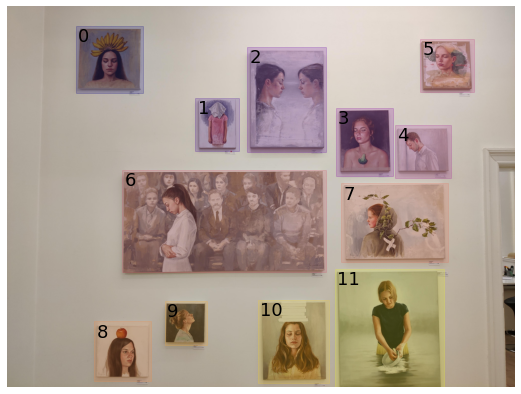

In [5]:
# define a colormap
aoi_colors = matplotlib.cm.get_cmap("plasma")
n_colorsteps = len(aois) - 1

# list the painting ids as names
paintings = [idx for idx in range(len(aois))]

# plot the reference image and overlay the AOIS
marked_ref_fig = plt.figure(figsize=(10, 7))
plt.imshow(np.asarray(reference_image))


def plot_aoi_patches(aois, ax, aoi_colors=aoi_colors, n_colorsteps=n_colorsteps):
    for idx, aoi in enumerate(aois):
        ax.add_patch(
            patches.Rectangle(
                aoi, *aoi[2:], alpha=0.2, color=aoi_colors(idx / n_colorsteps)
            )
        )
        ax.text(aoi[0] + 20, aoi[1] + 120, f"{idx}", color="black")


plot_aoi_patches(aois, plt.gca())
plt.gca().set_axis_off()

# Option: uncomment to save your visualisation
# marked_ref_fig.savefig('./figures/aois_on_reference_image_nested.png')

If you notice after looking at the overlay that some AOIs are not placed correctly, you can manually manipulate the location by changing entries in the aoi array.

If you notice that some AOIs are missing, or have been defined twice, you can also add them manually, or repeat the selection by executing the code cell "Marking Areas of Interest by Hand" again.

## Detecting Fixations Inside Areas of Interest 

Next up, we want to match the fixation coordinates to the AOIs. This is an iterative process, comparable to asking for every x/y coordinate pair that defines a fixation if that pair is inside any of the rectangles.

In [6]:
def check_in_rect(fixation_data, rectangle_coordinates):
    """
    returns an array with the length of fixation_data, which is True, when the entry in fixation_data
    was inside rectangle_coordinates and False otherwise.
    """

    # unpack the rectangle coordinates
    rect_x, rect_y, rect_width, rect_height = rectangle_coordinates

    # check if the fixation was within the x- and y-borders
    x_hit = fixation_data["fixation x [px]"].between(rect_x, rect_x + rect_width)
    y_hit = fixation_data["fixation y [px]"].between(rect_y, rect_y + rect_height)

    in_rect_idx = x_hit & y_hit

    return in_rect_idx


# create a new column of 'None's in our data frame
fixations["AOI"] = None

# assign the AOI ID to those fixations that were inside the AOI
for aoi_id, aoi in enumerate(aois):
    fixations.loc[check_in_rect(fixations, aoi), "AOI"] = paintings[aoi_id]

fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560236515914,200,True,2419.0,2138.0,None
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560480505914,223,True,2224.0,1717.0,6
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560740669914,240,True,2427.0,1559.0,6
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560972502914,196,True,1935.0,1119.0,2
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561168510914,159,True,2828.0,1668.0,7


You can now see the new column "AOI". This column indicates whether gaze fell inside a given AOI. We can viusalize this by plotting the fixations in a different color for each AOI.

## Plotting Fixations Inside and Outside Areas of Interest

In [7]:
def map_colors(idx, length, colors, fallback=[1, 1, 1, 1]):
    """
    This funcion maps the AOI ids to colors,
    using white as default color for fixations outside an AOI.
    """
    try:
        rgb = colors(idx / length)
    except TypeError:
        rgb = fallback
    return rgb

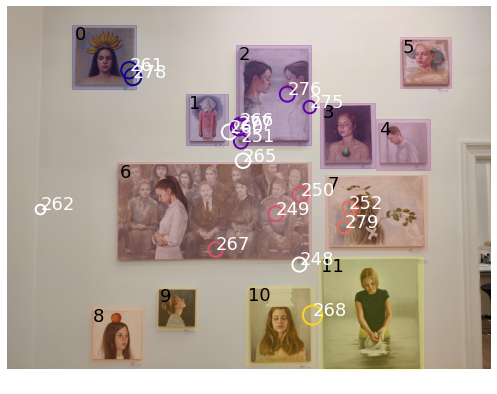

In [8]:
# filter a single subject for a less cluttered visualization
example_section = np.unique(fixations["section id"])[0]
example_fixations = fixations[fixations["section id"] == example_section]

aoi_fig = plt.figure(figsize=(10, 7))

# show the reference image
plt.imshow(np.asarray(reference_image))

# plot the aois
plot_aoi_patches(aois, plt.gca())

# plot fixations at their x- and y-position
plt.scatter(
    example_fixations["fixation x [px]"],
    example_fixations["fixation y [px]"],
    # change the face- and edgecolor to get circles rather than dots
    facecolor="none",
    edgecolor=[map_colors(x, n_colorsteps, aoi_colors) for x in example_fixations.AOI],
    linewidth=2,
    # set the size of the circles relative to the duration of each fixation
    s=example_fixations["duration [ms]"],
)

# ennumerate the fixations
for fix_id, x, y in zip(
    example_fixations["fixation id"],
    example_fixations["fixation x [px]"],
    example_fixations["fixation y [px]"],
):
    plt.annotate(fix_id, [x, y], color="white")

plt.gca().set_axis_off()

# Option: uncomment to save your visualisation
# aoi_fig.savefig('./figures/aois_fixations_on_reference_image_nested.png', bbox_inches='tight', pad_inches = 0);

On this visualization, we can check if the gaze positions were correctly detected inside their AOIs. The fixation circle should have the same color as the AOI, just a bit more opaque.


## Save the Fixation Data with Areas of Interest
To process the data further, we export the fixation data frame with AOIs to a new csv file. This step is important if you want to continue with the next notebook.

In [9]:
fixations.to_csv("fixations_with_aois_nested.csv", index = False)